In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with quantum Carleman and hybrid HHL 

In this tutorial, we solve the Susceptible-Exposed-Infectious-Recovered (SEIR) model, which describes the spread of a virus in a population on an epidemic level.<sup>1</sup> The SEIR model is a nonlinear dissipative system of quadratic ordinary differential equations (ODEs). 

We apply the quantum Carleman linearization algorithm to solve this problem. This algorithm consists of the following steps: Carleman linearization, discretization, truncation, and applying the forward Euler method. The resulting linear system of equations is solved using a popular quantum linear solver known as the Harrow-Hassidim-Lloyd (HHL) algorithm. This prototype evolved from two main articles: Liu et al. 2021 and Yalovetzky et al. 2021.<sup>2,3</sup>

#### Import packages

We begin by importing some useful packages, such as `NumPy`. 

In [2]:
# Packages
import numpy as np
import seaborn as sns
import timeit
import matplotlib.pyplot as plt

from scipy import sparse

import warnings
warnings.filterwarnings('ignore')

### Problem statement

Virus spread dynamics on an epidemic level are described by a weakly nonlinear system. A population that experiences virus spread 
can be divided into four classes: susceptible ($Ps$), exposed ($Pe$), infectious ($Pi$), and recovered ($Pr$). Over time, the 
amount of people who belong to each of these classes changes. For instance, at the beginning of an epidemic, a small part of the 
population is infectious and a large part is susceptible. As time passes, more people get exposed, and as a result, the population of 
infectious people increases until the moment a population has enough recovered people such that the virus can no longer transmit 
easily. The aim of quantum Carleman linearization is to predict the future populations.<sup>1,2</sup> 

Population change dynamics are described by a set of nonlinear ODEs. Hence, we expect the $P_s$, $P_e$, and $P_I$ to decrease over 
time, while $P_r$ increases. 

Next, we describe the ODEs capturing the dynamics:

##### Susceptible population

The susceptible population is expected to decrease over time due to two main drivers. First, susceptible people $P_s$ will be 
exposed to the virus by the infectious part of the population $P_I$ at a transmission rate ($r_tra$). Hence, this is the third term 
in the ODE and is responsible for the nonlinearity. Additionally, the negative sign indicates the decrease in $P_s$ that this 
process is driving. The second main driver, and the second term, describes the decrease driven by vaccination of the susceptible 
population. Finally, two terms, including $\Lambda$, remain. $\Lambda$ represents the influx of people outside the epidemic 
region who enter the population—for example, people traveling to a city where there is virus spread. Because the weights of 
each class of the population need to remain constant, we have:

$ \frac{d P_S}{dt} = - \Lambda \frac{P_S}{P} - r_{vac} P_S - r_{tra} P_S \frac{P_I}{P} + \Lambda$

##### Exposed population

The exposed population has both a decreasing term and an increasing term. The increasing term comes from the susceptible 
population ($P_s$) that is moving into the exposed population by a rate denoted $r_{tra}$. Again, this influx causes nonlinearity 
in the system. The decreasing force is the population that becomes infectious after the virus has gained momentum. Hence, the 
nonlinear increasing term needs to be smaller than the linear decreasing term. In other words, the system requires weak 
nonlinearity in order to avoid becoming a chaotic system. Furthermore, there is the $\Lambda$ correcting for people moving into the 
epidemic region. 

$ \frac{d P_E}{dt} = - \Lambda \frac{P_E}{P} - \frac{P_E}{T_{lat}} + r_{tra} P_S \frac{P_I}{P} $

##### Infectious population

The infectious population has both increasing and decreasing terms. As with all ODEs in this system, we have $\Lambda$ times the 
fraction of the population as an influx of new people to the epidemic area. Furthermore, the exposed population that becomes 
infectious after the latent time ($T_{lat}$) increases the population in this class. The decreasing behavior is driven by the people 
who recover after being infectious for a time $T_{inf}$.

$\frac{d P_I}{dt} = - \Lambda \frac{P_I}{P} + \frac{P_E}{T_{lat}} - \frac{P_I}{T_{inf}}$

##### Recovered population
The final class is the increasing part of the population that has recovered from the virus. This class grows due to two driving 
terms: first, people who recover from the virus after being infectious, which is indicated by the last term of this ODE; and second, 
the vaccinated people who move from the susceptible class into the recovered class after vaccination. The reducing term describes 
people moving in or out of the epidemic area.  

$\frac{d P_R}{dt} = - \Lambda \frac{P_R}{P} + r_{vac}P_S + \frac{P_I}{T_{inf}}$<br>

### Input variables 

The SEIR parameters are given below, which are obtained from Wang 2019.<sup>1</sup>

In [3]:
# Model parameters
r_vac = 0.19
r_tra = 0.13
T_lat = 5.2
T_inf = 2.3
Λ = 0.0
P = 1e7 # total population

p_tot = P
p_s0 = p_tot * 0.6
p_e0 = p_tot * 0.3
p_i0 = p_tot - p_s0 - p_e0

p0 = [p_s0, p_e0, p_i0]

### Carleman linearization 

The quantum Carleman linearization algorithm aims to predict the virus spread of the future population. The nonlinear system for 
virus spread dynamics in a population can be written as:

$$ \frac{d\hat{p}}{dt} = F_2 \hat{p}^{\otimes2} + F_1 \hat{p} + F_0(t),$$

where $\hat{p} \in R^n$ is the population, $F_0(t) \in R^n$ is time dependent, $F_1 \in R^{n \times n}$ contains the linear terms, 
and $F_2\in R^{n \times n^2}$ contains the nonlinear terms. Hence, both $F_1$ and $F_2$ are time-independent matrices. 

For the epidemic problem, $\hat{p} = \{P_S, P_E, P_I\}^T \in R^3$. Note, in the ODE, the term $P_R$ is not included. Because we assume 
the population remains constant $P = P_S +P_E +P_I +P_R$, we do not need to compute $P_R$. Therefore, the $\hat{p}$ vector has $n=3$, 
which corresponds to the number of ODEs in the system. 

Furthermore, $\hat{p}^{\otimes2}$ is the Kronecker power, which is equal to $\hat{p}\otimes\hat{p} = \{P_SP_S, P_SP_E,P_SP_I, P_EP_S, P_EP_E,P_EP_I,P_IP_S,P_IP_E,P_IP_I\}^T$ with the dimension $R^{n^2}$.

The following $F_0\in R^{3\times 1}$, $F_1 \in R^{3\times 3}$, and $F_2\in R^{3\times 3^2}$ are found: 
- $ F_0 = \begin{bmatrix}\Lambda \\ 0 \\ 0 \end{bmatrix}$<br>

- $F_1 =  \begin{bmatrix} -\frac{\Lambda}{P}-r_{vac} & 0 & 0 \\0 & -\frac{\Lambda}{P}- \frac{1}{T_{lat}} & 0 \\0 & \frac{1}{T_{lat}} & -\frac{\Lambda}{P}- \frac{1}{T_{inf}} \end{bmatrix}$<br>

- $F_2 =  \begin{bmatrix} 0 & 0 & -\frac{r_{tra}}{P} & 0 & 0 & 0 & 0 & 0 & 0 \\0 & 0 & \frac{r_{tra}}{P} & 0 & 0 & 0 & 0 & 0 & 0 \\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}. $<br>


The code below creates the $F_0$, $F_1$, and $F_2$ matrices from the input variables given in the previous code cell. 

In [4]:
# SEIR model function returns matrics F_2, F_1

def seir_model_carlin(r_vac, r_tra, T_lat, T_inf, Λ, P):
    F1 = np.zeros((3, 3))
    F1[0, 0] = -Λ/P -r_vac
    F1[1, 1] = -Λ/P -1/T_lat
    F1[2, 1] = 1/T_lat
    F1[2, 2] = -Λ/P -1/T_inf

    F2 = np.zeros((3, 9)) # [x, x⊗x]
    F2[0, 2] = -r_tra/P
    F2[1, 2] = r_tra/P
    return F1, F2

In [5]:
# Create F1 and F2 matrices
f = seir_model_carlin(r_vac, r_tra, T_lat, T_inf, Λ, P)

f1 = f[0] # dim 3x3
f2 = f[1] # dim 3x9

#### Quantum Carleman linearization for dissipative nonlinear systems

The quantum Carleman linearization scheme is divided into two main steps, namely Carleman linearization and the forward Euler 
method. Carleman linearization aims to map the nonlinear system, $ \frac{d\hat{p}}{dt} = F_2 \hat{p}^{\otimes2} + 
F_1 \hat{p} + F_0$, to a linear form $\frac{dy}{dt}=A\hat{y} +b$. Here, $\hat{y}$ is called the auxiliary variable and $A$ is the 
matrix of coefficients. Next, the forward Euler scheme is used to discretize the system of ODEs, resulting in a system of linear 
equations. The linear system is then solved using the HHL algorithm. 

##### Compose $\hat{y}$

The first step of Carleman linearization is to create the auxiliary variable, $\hat{y}$. The auxiliary variable is defined as $\hat{y_j} = x^{\otimes j}\in R^{n^j}$, where $j$ is the truncation level. For this use case, we choose $j=2$, which yields the following for the SEIR application:
- $\hat{y_1}= x = \hat{p} \in R^n$
- $\hat{y_2}= x^{\otimes 2} = \hat{p}^{\otimes 2}\in R^{n^2}$


In [6]:
# Create auxiliary variables, truncation level N=2
y01 = p0 # y01 equals P = [S,E,I]
y02 = [] # y02 equals P ⊗ P = [SS,SE,SI, ES, EE, EI,IS, IE, II]

for i in range(0, len(p0)):
    for j in range(0, len(p0)):
        y02.append(p0[i]*p0[j])

#y = [y1,y2]
y0 = np.concatenate([y01,y02], axis=0) # y = [P, P ⊗ P] = [S,E,I,SS,SE,SI, ES, EE, EI,IS, IE, II], with dim 3+9 = 12
print(len(y0))


12


##### Compose matrix $A$

The coefficient matrix $A$ has a bidiagonal block structure and consists of several transfer matrices. Three types of transfer matrices exist, namely $A^i_{i+1}, A^i_i, A^i_{i-1}$. These are given by:

- $A^j_{j+1} = F_2 \otimes I^{\otimes j-1} + I \otimes F_2 \otimes I^{j-2} + ... + I^{\otimes j-1} \otimes F_2$, with dimension $ R^{n^j \times n^{j+1}}$
- $A^j_{j} = F_1 \otimes I^{\otimes j-1} + I \otimes F_1 \otimes I^{j-2} + ... + I^{\otimes j-1} \otimes F_1$, with dimension $ R^{n^j \times n^{j}}$
- $A^j_{j-1} = F_0(t) \otimes I^{\otimes j-1} + I \otimes F_0(t) \otimes I^{j-2} + ... + I^{\otimes j-1} \otimes F_0(t)$, with dimension $ R^{n^j \times n^{j-1}}$

For the SEIR model, this results in the following transfer matrices:

- $A^1_1 = F_1$
- $A^1_2 = F_2$
- $A^2_1 = 0$
- $A^2_1 = F_1 \otimes I + I \otimes F_1$

The code below constructs the block matrices. 

In [7]:
# Initialize A-matrix 
# Note: dy/dt = Ay + b, and with y0 we could obtain the y'.

# Construct the full A matrix, dim 12x12 for truncation level N = 2.
# First we construct the four block matrices of Matrix A. Second, we put them together into matrix A.
# A = ([a11,a12,],[0,a22])
identity = np.identity(3)

# Step 1. Construct block As 
# a11 = F1, dim 3x3
a11 = f[0]

# a12 = F2, dim 3x9
a12 = f[1]

#a21 = zeros, dim 9x3
a21 = np.zeros((9,3))

# a22 = F1 ⊗ I + I ⊗ F1, dim 9x9
a22 = sparse.kron(f1,identity).toarray() + sparse.kron(identity,f1).toarray()

# Step 2. insert blocks into A 
#A = [[a11,a12],[a21,a22]]
A = [[a11,a12],[a21,a22]]

In [8]:
# Concatenate as needed to get matrix A in the correct format for plotting
row1i = np.concatenate((a11,a12), axis = 1)
row2i = np.concatenate((a21,a22), axis = 1)
A_complet = np.concatenate((row1i,row2i), axis =0)

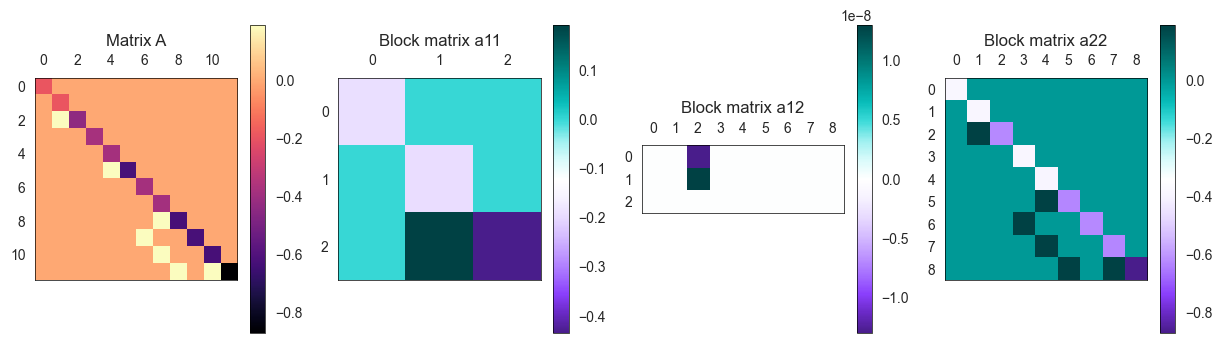

In [9]:
# Plot of matrix A and subplots of the block matrices within matrix A.
# Subplots show a11, a12, and a22. a21 contains only zeros and is not displayed.
fig, axes = plt.subplots(ncols= 4, figsize=(15, 4))

ax1, ax2,ax3,ax4 = axes

# Plot matrix A and blocks within matrix A 
im1 = ax1.matshow(A_complet, cmap='magma')
im2 = ax2.matshow(a11)
im3 = ax3.matshow(a12)
im4 = ax4.matshow(a22)


# Set titles
ax1.set_title('Matrix A')
ax2.set_title('Block matrix a11') 
ax3.set_title('Block matrix a12') # subplot shows small values, which are not shown by the color gradient in the matrix A
ax4.set_title('Block matrix a22') 


# Set the color bar on the side
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)

The first graph (on the left) shows the $A$ matrix (orange) along with three block matrices (green). Only three of the four block matrices are displayed, as the missing one, “a21,” contains only zeros. Additionally, the second block matrix, “a12,” contains values close to zero. Therefore, in the orange graph of the entire matrix, these values are not visible. 

#### Apply the forward Euler method

After the linear embedding of the quadratic ODEs, we apply the forward Euler method to solve the system for future times. 
For computations to finish in a reasonable amount of time, we demonstrate forward Euler only for one time step.

Applying the forward Euler method to the linear system for one time step yields the following:

$$ \begin{bmatrix} I & 0 \\ -[I+A(0)h] & I \end{bmatrix} \begin{bmatrix} y^0 \\y^1 \end{bmatrix} = \begin{bmatrix}
y_{in} \\ b(0)\end{bmatrix}, $$

where $\hat{y}$ contains the population at time zero ($y_0$), the first three entries of $y_1$ contain our solution of the future population at $t=1$, $I\in \mathbb{R}^{12x12}$ is the identity matrix, $y_{in}$ is the population at time $t=0$, and $b(0)$ is our bias term. A detailed derivation of the above equation can be found in Liu et al. 2021.<sup>2</sup>

The code below constructs the above matrix and displays this matrix as a heat map graph (red). 


(24, 24)


Text(0.5, 1.0, 'Matrix for Forward Euler, k=1')

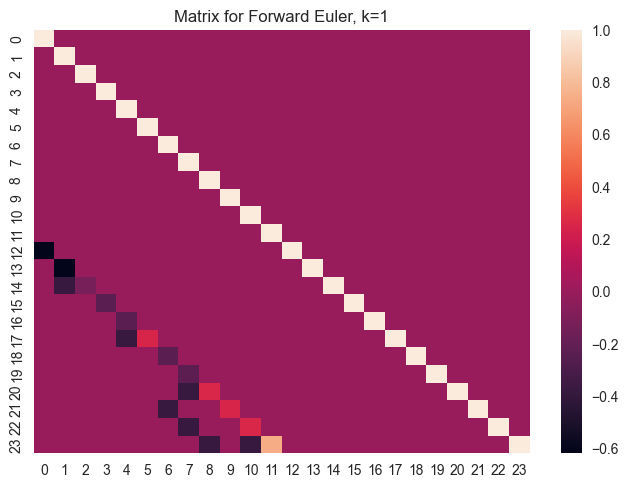

In [10]:
# Create matrix E which is used for the forward Euler. 
# First time step: [[I, 0],[-(I+A*h), I]][y0, y1] = [0], dim E 24x24, dim y 24x1, dim 0 24x1
# Page 5 of Carleman paper equation (3.11)

h = 2 # time step h = dt

I12 = identity = np.identity(12)
Ah = A_complet *h

e11 = I12
e12 = np.zeros((12,12))
e21 = -1*(I12 + Ah)
e22 = I12

euler_matrix = [np.concatenate((e11,e12), axis = 1), np.concatenate((e21,e22), axis = 1)]
euler_matrix_complete = np.concatenate((euler_matrix[0],euler_matrix[1]), axis = 0)
print(euler_matrix_complete.shape)

res = euler_matrix_complete
ax = sns.heatmap(res)
euler_matrix_complete.shape
ax.set_title('Matrix for Forward Euler, k=1')



Next, we construct the $\begin{bmatrix} y_{in} \\ b(0)\end{bmatrix}$ vector. Note that $b(0)$ contains merely zeros.

In [11]:
# Create x = [y0,0], of Ax = b
b2 = np.zeros((12))
b = np.concatenate((y0,b2), axis = 0)
b

array([6.0e+06, 3.0e+06, 1.0e+06, 3.6e+13, 1.8e+13, 6.0e+12, 1.8e+13,
       9.0e+12, 3.0e+12, 6.0e+12, 3.0e+12, 1.0e+12, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00])

Below we compute the Forward Euler classically to demonstrate the idea. For one time step we can solve it classically. However, 
taking a higher truncation level, larger non-linear system, and/or more time steps, computations will take longer. 

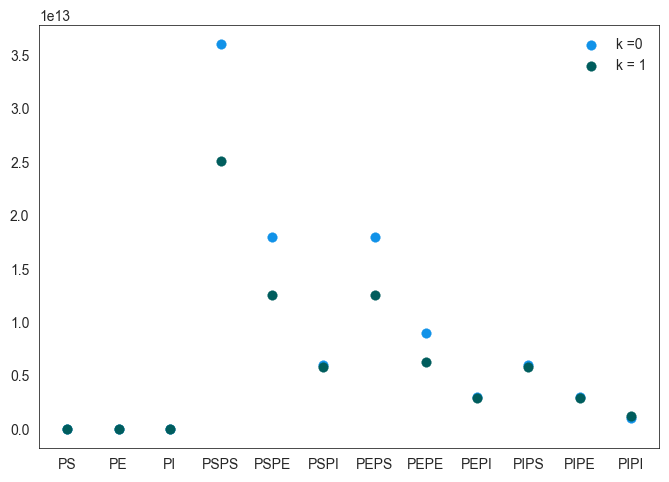

In [12]:
# Forward Euler steps hardcoded classically
h = 0.8 # time step h = dt

# y1
Ayh = np.dot(A_complet,y0)*h
Iy = np.dot(np.identity(12), y0)
yt1h = (Iy + Ayh) #hence f_euler is y1. We can continue this until the the total number of desired time steps. 


x = ["PS","PE","PI","PSPS","PSPE","PSPI","PEPS","PEPE","PEPI","PIPS","PIPE","PIPI"]
plt.scatter(x,y0, label = "k =0")
plt.scatter(x,yt1h, label = "k = 1")
plt.legend()


In [13]:
yt1h

array([5.02560000e+06, 2.60086154e+06, 1.11371237e+06, 2.50560000e+13,
       1.24947692e+13, 5.77027425e+12, 1.24947692e+13, 6.23076923e+12,
       2.87959866e+12, 5.77027425e+12, 2.87959866e+12, 1.22742475e+12])

The code below plots only the $P_S$, $P_E$, and $P_I$ for the two time steps. 

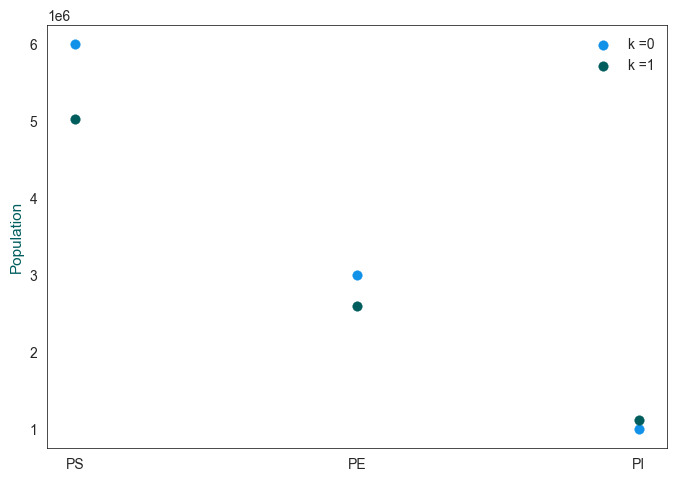

In [14]:
x3 = ["PS","PE", "PI"]
yt1h_test = [yt1h[0],yt1h[1],yt1h[2]]

plt.scatter(x3,y01, label = "k =0")
plt.scatter(x3,yt1h_test, label = "k =1")
plt.ylabel("Population")
plt.legend()


#### Apply HHL

In the second part of this tutorial, we focus on a hybrid quantum algorithm based on the HHL algorithm. We show how the [Qiskit HHL](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html) algorithm can be used to solve the epidemic model after Carleman linearization.<sup>4</sup> In the following sections, you will learn how to set up and solve a system of linear equations using the HHL algorithm. 

We begin by importing some useful packages such as `Qiskit`. This includes the `qiskit.algorithms.linear_solvers` library, which 
has many important modules to aid us in finding an approximate solution to our problem. To solve the linear equation part specifically, we use 
the modules `linear_solvers.matrices`, `linear_solvers.numpy_linear_solver.NumPyLinearSolver`, and `qiskit.algorithms.linear_solvers.hhl`.

In [15]:
# Packages 
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL

from qiskit.circuit import QuantumCircuit

from numpy import linalg as LA
np.set_printoptions(linewidth=100)


###  Set up a linear system
Recall, the following differential equation is obtained after we transformed the nonlinear dissipative system into a linear system 
by using the Carleman linearization scheme, which yields

$$\frac{d\hat{y}}{dt} = A(t)\hat{y}+b(t), \quad \hat{y}(0) = \hat{y}_{in}$$

Further, applying the forward Euler scheme for discretization yields

$$y^{k+1}=[I+A(kh)h]y^k+b(hk)$$

A recursion relation, as stated above, demands reading output $y^{k+1}$ at every time step. Such a scheme may seem natural 
classically, but for a quantum computer it is not ideal due to the exponential cost of readouts. 

On a quantum computer, the trick is to use a “clock” state with an additional register that stores time steps. Hence, a quantum state of the form 

\begin{equation}
    \vert\boldsymbol{y}\rangle = \frac{1}{\sqrt{T}}\sum_{j=0}^{T-1} \vert{t_j}\rangle \vert{y_j}\rangle
\end{equation}


is introduced, where $T$ is the number of time steps. 

Specifically, we solve the following system
$A\lvert Y \rangle=\lvert B \rangle$ (as given below), instead of the original one:

\begin{align}
    \begin{bmatrix}
         I  \\
        -(I+h A(0)) & I  \\
         & \ddots & \ddots   \\
         & & -(I+h A(h(T-1))) & I \\
         & & & -I & I \\
         & & & & -I & I \\
         & & & & & \ddots & \ddots \\
         & & & & & & -I & I
    \end{bmatrix}
    %
    \begin{bmatrix}
        y_0 \\
        y_1 \\
        \vdots \\
        y_{T-1} \\
        y_{T} \\
        y_{T+1} \\
        \vdots \\
        y_{2T-2} 
    \end{bmatrix}
    =
    \begin{bmatrix}
        (I+h A(0)) y_{0} + h b_0 \\
        h b_1 \\
        \vdots  \\
        h b_{T-1} \\
        0 \\
        0 \\
        \vdots \\
        0
    \end{bmatrix},
\end{align} 

where the last rows have $y_{j+1}=y_j$ when $j> T-1$ keep the value of $y_j$ constant. This padding scheme improves 
the probability of successfully obtaining $y_{T}$ from the clock state 
$\vert\boldsymbol{y}\rangle = \frac{1}{\sqrt{T}}\sum_{j=0}^{T-1} \vert{t_j}\rangle\vert{y_j}\rangle$ after the time register is read out. For details, see Ref [[4]](#QiskitHHL).

To solve the linear system of equations, we use a quantum algorithm known as HHL. For our use case, we work only with two
time steps, that is, $k\in\{0,1\}$, which results in 

$$ \begin{bmatrix} I & 0 \\ -[I+A(0)h] & I \end{bmatrix} \begin{bmatrix} y^0 \\y^1 \end{bmatrix} = \begin{bmatrix}
y_{in} \\ b(0)\end{bmatrix}.   $$

The entries of the $\hat{y}$ vector contain the population at each time $t$, respectively. 

#### Import matrix $A$ and vector $b$

In [16]:
vector_b = b

In [17]:
matrix_A = euler_matrix_complete
matrix_A.shape

(24, 24)

#### Steps before HHL

To use the HHL algorithm for problem $Ax=b$, we need to meet the following conditions:
* Because the vector $\vec{b}$ is loaded as a quantum state, the entries of $b$ must be normalized so that the normalized 
vector has a unit norm. 
* Matrix $A$ needs to be Hermitian.
* Matrix $A$ and vector $b$ must have dimensions as powers of 2. 

##### Normalize vector $b$

Vector $b$ needs to be normalized such that it represents a unit vector in our quantum circuit.<sup>5</sup>

For vector $b$, this yields
$\sum^{2^{i}}_{j=0} |b_j|^2=1.$

In [18]:
vector_b_norm = vector_b/(np.linalg.norm(vector_b))
vector_b_norm

array([1.30434783e-07, 6.52173913e-08, 2.17391304e-08, 7.82608696e-01, 3.91304348e-01,
       1.30434783e-01, 3.91304348e-01, 1.95652174e-01, 6.52173913e-02, 1.30434783e-01,
       6.52173913e-02, 2.17391304e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

##### Expand the dimensions $A$ and $b$

Because the quantum circuit can accept only matrices of dimension $2^i$, we need to expand our matrix $A\in\mathbb{R}^{24\times24}$ 
and $b\in \mathbb{R}^{24 \times 1}$ to dimensions of $2^5 = 32$. 
In essence, we do this by defining a new matrix,

$$
A^{'} = \begin{pmatrix} 0 & A \\
I & 0\end{pmatrix},
$$
with an identity matrix $I$ of the smallest dimension needed to make the dimension of matrix $A^{'}$ powers of 2. For example,
in our case, we need the dimension of $I$ to be $32 - 24=8$. We also need a new vector $\lvert b^{'} \rangle = \begin{pmatrix} b \\ 0\end{pmatrix}$ padded with a vector containing zeros of length $8$. Note that as a result, the solution is encoded as another padded vector of the form 
$\lvert x^{'} \rangle = \begin{pmatrix} 0 \\ A^{-1}\lvert b \rangle \end{pmatrix}$. The `expand_to_powerdim` function below
implements such a scheme.

In [19]:
def expand_to_powerdim(matrix, vector):
        """ 
        Qiskit 0.19
        
        Expand a matrix to the next-larger 2**n dimensional matrix with
        ones on the diagonal and zeros on the off-diagonal and expand the
        vector with zeros accordingly.

        Args:
            matrix (np.array): the input matrix
            vector (np.array): the input vector

        Returns:
           tuple(np.array, np.array): the expanded matrix, the expanded vector
        """
        #[[0,A],[I,0]]
        #
        mat_dim = matrix.shape[0] #(24,24)
        next_higher = int(np.ceil(np.log2(mat_dim))) # 5
        size_I= (2**next_higher) - mat_dim
        print(size_I)
        new_matrix = np.zeros((2 ** next_higher,2 ** next_higher), dtype=complex) # A_prime -> skeleton
        # new_matrix = np.matrix(new_matrix, dtype=complex) # make complex
        print(new_matrix.shape)
        identity = np.identity(size_I, dtype=complex)
        new_matrix[0:mat_dim, size_I:] = matrix[:, :] # place A to new_matrix
        new_matrix[mat_dim:, 0:size_I] = identity[:, :]


        new_vector = np.zeros((1, 2 ** next_higher))# create zeros
        new_vector[0, :mat_dim] = vector #24
        new_vector = new_vector.reshape(np.shape(new_vector)[1])
        return new_matrix, new_vector

In [20]:
# Added vector_b_norm
vector_b_norm = vector_b/np.linalg.norm(vector_b)
print("length norm: ", len(vector_b_norm))

matrix_A_H, vector_b_H = expand_to_powerdim(matrix_A, vector_b_norm)
print("Dimension matrix A: ",matrix_A_H.shape)
print("Length vector b: ", len(vector_b_H))

length norm:  24
8
(32, 32)
Dimension matrix A:  (32, 32)
Length vector b:  32


##### Make matrix $A$ Hermitian

To solve the resulting system $A^{'}\lvert x^{'} \rangle = \lvert b^{'} \rangle$ with HHL, the matrix $A^{'}$ should be 
Hermitian. For this problem, we obtain the Hermitian matrix by multiplying both sides of the equation with the conjugate transpose, 
$A^{\dagger}$, which yields $A^{\dagger}A x = A^{\dagger}b.$

In real situations, as multiplications are computationally expensive, the preferred method is to create another matrix of the form

$$
 A^{'}_H = \begin{pmatrix} 0 & A \\ A^{\dagger} & 0 \end{pmatrix}.
$$

However, this scheme doubles the size of the matrix and needs one more qubit. In this tutorial, to save qubits, we use the first method.

In [21]:
# Make matrix A Hermitian
matrix_A_H_new = np.matmul(matrix_A_H.T, matrix_A_H)
vector_b_H_new = matrix_A_H.T.dot(vector_b_H) #b=[yi, zeros] A=[I,0][alpha,I] 

In [22]:
# Vector_b = vector_b/(np.linalg.norm(vector_b))
print("vector_b_H: ", np.linalg.norm(vector_b_H))
print("vector_b: ",np.linalg.norm(vector_b_norm))
print("vector_b_H_new: ",np.linalg.norm(vector_b_H_new))
print("Matirx_A_H_new: ", matrix_A_H_new.shape)

vector_b_H:  0.9999999999999999
vector_b:  0.9999999999999999
vector_b_H_new:  0.9999999999999998
Matirx_A_H_new:  (32, 32)


##### Run HHL algorithm to solve the problem

In [23]:
# Create b register
circuit_epsi_01 = QuantumCircuit(5)
circuit_epsi_01.initialize(vector_b_H_new/np.linalg.norm(vector_b_H_new))

In [24]:
# Run HHL algorithm
start_time = timeit.default_timer()

naive_hhl_solution_epsi_01 = HHL(epsilon=0.1).solve(matrix_A_H_new/np.linalg.norm(matrix_A_H_new), circuit_epsi_01)

# Code you want to evaluate
elapsed = timeit.default_timer() - start_time
elapsed

750.7481240829802

You may have noticed that we are feeding a matrix to HHL whose elements are scaled by its norm. Because such a scaling improves 
the condition number of the matrix, it improves the run time of the algorithm. Note, HHL still roughly took around 20 minutes to
finish on a personal laptop with 32 GB RAM. One can further improve the condition number by preconditioning algorithms as well. For 
more details, please see Clader 2013<sup>6</sup> and subsequent work.

#### Compare the results using the Euclidean norm

Here, we compare the results using the Euclidean norm. The Euclidean norm, also called the $\mathbb{L}_2$ norm, of a quantum state is defined as
$\lVert \vert x \rangle \rVert_2 = \sqrt{\sum_{i=1}^N \lvert x \rvert^2}$.

In [25]:
naive_hhl_solution_epsi_01.euclidean_norm

6.941347998315539

### Classical solution

In [26]:
classical_solution = NumPyLinearSolver().solve(matrix_A_H_new/np.linalg.norm(matrix_A_H_new), vector_b_H_new/np.linalg.norm(vector_b_H_new))
classical_solution.euclidean_norm

6.990557948531629

In [27]:
print("--- Results Euclidean norm ---")
print("Classical: ", classical_solution.euclidean_norm)
print("Quantum: ", naive_hhl_solution_epsi_01.euclidean_norm)

--- Results Euclidean norm ---
Classical:  6.990557948531629
Quantum:  6.941347998315539


The solution obtained is a state of the form $\frac{1}{\sqrt{2}}\bigg(\vert{y^0}\rangle \vert0 \rangle + \vert y^1 \rangle \vert 1\rangle \bigg)$. In general, we
have $\vert{\psi}\rangle=\frac{1}{\sqrt{N_T}}\sum_{k=0}^{N_T-1}\vert{y^k}\rangle\vert{t_k}\rangle$, where $\vert{y^k}\rangle$ is entangled with a state 
$\vert{t_k}\rangle$ that denotes the time step. Here $N_T$ denotes the number of time steps. Hence, in our case, if we want to read 
$y^{1}$, we would first read the second register (time step) register, and once we observe a state $1$ there, then we can 
be sure that state $\vert{y^1}\rangle$ is present on the first register. Note that the probability of observing a state 
$\propto \frac{1}{N_T}$. In order to improve the probability of observing a state at the last time step, for example, usually the matrix $L$ (see above) is padded with rows containing identity matrices (see Berry 2014<sup>7</sup>).

Now, as $\vert{y^k}\rangle = [S, E, I, SS , SE, SI, ES, EE, EI, IS, IE, II]_k,$ what if one wants to read 
one of the components of $\vert{y^k}\rangle$? Let’s write $\vert{y^k}\rangle= \sum_j b_j \vert{j}\rangle$, where $\vert{j}\rangle$ are standard basis 
states. Then, $b_j^2 = \langle{y_k}\vert M\vert{y_k}\rangle$, where $M = \vert{j}\rangle\langle{j}\vert$. Hence, any component $b_j$ can be obtained by
computing the expectation of $M$ for the quantum state $\vert{y^k}\rangle.$ Note that the operator $M$ can be written as a sum of Pauli strings containing $Z$ and $I$ operators.


### Summary

Possible extensions may include solving similar nonlinear differential equations found in fluid flow and heat transfer processes.


### References

1. <a id='Wang2019'></a>Chaolong Wang et al. “Evolving Epidemiology and Impact of Non-pharmaceutical Interventions on the Outbreak of Coronavirus Disease 2019 in Wuhan, China.” medRxiv:2020.03.03.20030593v1, March 3, 2020. [https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1](https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1).

2. <a id='Childs2021'></a>Jin-Peng Liu et al. “Efficient Quantum Algorithm for Dissipative Nonlinear Differential Equations.” *PNAS*, vol. 118, no. 35 (2021). [https://www.pnas.org/doi/abs/10.1073/pnas.2026805118](https://www.pnas.org/doi/abs/10.1073/pnas.2026805118).

3. <a id='Pistoia2021'></a>Romina Yalovetzky et al. “NISQ-HHL: Portfolio Optimization for Near-Term Quantum Hardware.” arXiv:2110.15958v4, 2021. [https://arxiv.org/pdf/2110.15958.pdf](https://arxiv.org/pdf/2110.15958.pdf).


4. <a id='QiskitHHL'></a>“Solving Linear Systems of Equations Using HHL.” *Qiskit*. [https://qiskit.org/textbook/ch-applications/hhl_tutorial.html](https://qiskit.org/textbook/ch-applications/hhl_tutorial.html).


5. <a id='Wong2021'></a>Anika Zaman, Hector Jose Morrell, and Hiu Yung Wong. “A Step-by-Step HHL Algorithm Walkthrough to Enhance Understanding of Critical Quantum 
Computing Concepts.” arXiv:2108.09004, 2021. [https://arxiv.org/pdf/2108.09004.pdf](https://arxiv.org/pdf/2108.09004.pdf).

6. <a id='Clader2013'></a>B. D. Clader, B. C. Jacobs, and C. R. Sprouse. “Preconditioned Quantum Linear System Algorithm.” arXiv:1301.2340, May 7, 2013. [https://arxiv.org/abs/1301.2340](https://arxiv.org/abs/1301.2340).

7. <a id='Berry2014'></a>Dominic W. Berry. “High-Order Quantum Algorithm for Solving Linear Differential Equations.” arXiv:1010.2745, January 28, 2014. [https://arxiv.org/abs/1010.2745](https://arxiv.org/abs/1010.2745).






<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>